<h3> Training BiLSTM Model </h3>

In [1]:
import pandas as pd
import os
import re
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import gensim
from gensim.models import Word2Vec

# BiLSTM Model Training

This notebook implements the BiLSTM model which will take TF-IDF based symptom representation and Word2Vec based symptom representation and predicts diagnoses codes.

---

- Input : symptom_disease_dict_{RUN_TAG}.json - Contains HADM_ID to Symptom text and Diagnosis mapping as json object
- Input : icd9_dict_{RUN_TAG}.json - Contains ICD9 Codes of TOP N Diagnoses
- Input : weight_i_j_norm{tag}.csv - TF-IDF weights for symptom representation

In [2]:
cwd = os.getcwd()
print(f"Current working directory : {cwd}")
# Let's define some constants that will be used below in our processing
MAX_NUMBER_OF_DISEASE = 100
MAX_SYMPTOMS = 50
BATCH_SIZE=400
WORD2VEC_NUM_FEATURES = 128
RUN_TAG = f"_{MAX_NUMBER_OF_DISEASE}_v2.0"
data_dir = cwd + "/../../data/"
SYMPTOM_DISEASE_DICT_FILE_PATH = data_dir + f"symptom_disease_dict_{RUN_TAG}.json"
ICD9_FILE_PATH = data_dir + f"icd9_dict_{RUN_TAG}.json"
SYMPTOM_DICT_FILE_PATH = data_dir + f"symptoms_dict_{RUN_TAG}.json"
TF_IDF_WEIGHTS_FILE_PATH = data_dir + f"weight_i_j_{RUN_TAG}.csv"
TF_IDF_NORM_WEIGHTS_FILE_PATH = data_dir + f"weight_i_j_norm_{RUN_TAG}.csv"

MODEL_DIR = data_dir + "/word2vec/"
# Word2Vec model will not change much - so keeping fixed file name
MODEL_FILE_PATH = MODEL_DIR + f"word2vec_model_sg_128__v2.0"
DISEASE_THRESHOLD = 0.20
SYMPTOM_TO_DIAGNOSE_MODEL_FILE= data_dir + f"symptom_diagnoses{RUN_TAG}_ablation.model"
SYMPTOM_TO_SYMPTOM_MODEL_FILE= data_dir + f"symptom_symptom{RUN_TAG}_ablation.model"
RESULTS_FILE_PATH = data_dir + f"results_{RUN_TAG}_ablation.json"

Current working directory : /Users/vijaymi/Studies/CS-598-DL4Health/Project/135-Disease-Inference-Method/disease_pred_using_bilstm/source


## 1. Loading all the required data

In [3]:
icd9_dict = None
with open(ICD9_FILE_PATH, 'r') as f:
            icd9_dict = json.load(f)
        
symptom_disease_dict = None
with open(SYMPTOM_DISEASE_DICT_FILE_PATH, 'r') as f:
            symptom_disease_dict = json.load(f)

symptoms_dict = None
with open(SYMPTOM_DICT_FILE_PATH, 'r') as f:
    symptoms_dict = json.load(f)

# Loading saved Word2Vec Model 
word2vec_model = gensim.models.Word2Vec.load(MODEL_FILE_PATH)
    
tfidf_weights = pd.read_csv(TF_IDF_NORM_WEIGHTS_FILE_PATH)
tfidf_weights.head()

,0,1,2,3,4,5,6,7,8,9,...,4016,4017,4018,4019,4020,4021,4022,4023,4024,4025
0,0.328974,0.0,0.0,0.348214,0.200701,0.0,0.0,0.0,0.0,0.817708,...,0.090909,0.666667,0.125,0.833333,0.666667,0.714286,0.500000,1.000,0.2,1.000
1,0.096579,0.0,0.0,0.171429,0.716152,0.0,0.0,0.0,0.0,0.802083,...,0.272727,0.000000,0.625,0.500000,0.111111,0.571429,0.333333,0.500,0.4,0.500
2,0.545272,0.0,0.0,0.498214,0.632686,0.0,0.0,0.0,0.0,1.000000,...,0.545455,0.666667,0.375,0.500000,0.666667,0.714286,0.833333,0.875,0.6,0.000
3,0.162978,0.0,0.0,0.300000,0.620580,0.0,0.0,0.0,0.0,0.739583,...,0.090909,0.166667,0.500,0.333333,0.222222,0.285714,0.166667,0.250,0.0,0.500
4,0.270624,0.0,0.0,0.294643,0.490284,0.0,0.0,0.0,0.0,0.630208,...,0.000000,0.166667,0.125,0.500000,0.111111,0.428571,0.500000,0.875,0.2,0.625


## 2. Symptom to Disease BiLSTM Model (for TF-IDF based Symptom representation)

### 2.1 Define Custom Loader for Symtom to Diagnoses based BiLSTM Model

In [4]:
from torch.utils.data import Dataset

class SymptomCustomDataset(Dataset):
    
    def __init__(self, filename, tfidf_weights, word2vec_model):        
        self.hadm_id_map = {}
        self.word2vec_embedding_cache = {}
        self.tfidf_embedding_cache = {}
        
        # TF-IDF Weights
        self.tfidf_weights = tfidf_weights
        
        # Word2Vec model
        self.model_w2v = word2vec_model.wv
        
        # Symptom dictionary
        with open(SYMPTOM_DICT_FILE_PATH, 'r') as f:
            self.symptom_dict = json.load(f)
        
        with open(ICD9_FILE_PATH, 'r') as f:
            self.icd9_dict = json.load(f)
        
        # read in the data files
        self.hadm_list = self.process_raw_data(filename)
        
        
    def process_raw_data(self, filename):
        symptom_disease_dict = None
        with open(filename, 'r') as f:
            symptom_disease_dict = json.load(f)
        hadm_list = []

        # Collecting all records for one admission as a tuple of symptoms list and diagnoses list
        # for hadm_id in list(symptom_disease_dict.keys())[:30000]:    
        for hadm_id in list(symptom_disease_dict.keys()):            
            symp_list, icd9_list = symptom_disease_dict[hadm_id]
            
            # TF-IDF - Matrix of size (MAX_SYMPTOMS, MAX_NUMBER_OF_DISEASE)
            tfidf_symp_vec = self.create_symptom_vector_with_tfidf(symp_list)
            if tfidf_symp_vec is None:
                continue
            
            # Word2Vec - Matrix of size (MAX_SYMPTOMS, MAX_NUMBER_OF_DISEASE)
            w2v_symp_vec = self.create_symptom_vector_with_word2vec(symp_list)
            
            # Processing Diagnoses Code - Series of size MAX_NUMBER_OF_DISEASE
            diag_vec = self.create_diagnosis_vector(icd9_list)

            # Save all three in hadm list
            hadm_list.append((tfidf_symp_vec, w2v_symp_vec, diag_vec, symp_list))
        
        return hadm_list
        
    def __len__(self):
        return len(self.hadm_list)
    
    def __getitem__(self, index):
        """
            Output:
            tf-idf symptpm_vector : number_of_diagnoses (50) x max_number_of_symptoms (50)
            word2vec symptpm_vector : max_number_of_symptoms (126) x number_of_diagnoses (50)
            diagnoses_vector = number_of_diagnoses
            symptom_count = number of symtoms for current record
        """
        tfidf_symp_vec, w2v_symp_vec, diag_vec, symp_list = self.hadm_list[index]
        
        # Create symptom vector for this admission record
        return torch.tensor(tfidf_symp_vec.T, dtype=torch.float), torch.tensor(w2v_symp_vec.T, dtype=torch.float), torch.tensor(diag_vec, dtype=torch.float), len(symp_list)
    
    def create_symptom_vector_with_tfidf(self, symp_list):
        # Convert Symptom text list to symptom index list
        symptom_idx_list = self.generate_tfidf_based_embedding(symp_list)
        
        if len(symptom_idx_list) == 0:
            return None
        
        symptom_vector = np.zeros((MAX_NUMBER_OF_DISEASE, MAX_SYMPTOMS))
        # Populate Symptom Vector by getting corresponding embeddings from TF-IDF vector
        for index, symptom_idx in enumerate(symptom_idx_list):
            # print(f"Symptom vector index: {index}, symptom index : {symptom_idx} \n {self.tfidf_weights.iloc[:,symptom_idx]}")
            symptom_vector[:, index] = self.tfidf_weights.iloc[:,symptom_idx]
        
        return symptom_vector
        

    def create_symptom_vector_with_word2vec(self, symp_list):
        # Create a 2d vector of symptoms (X)
        symp_vec = np.zeros((WORD2VEC_NUM_FEATURES, MAX_SYMPTOMS))
        
        # We take max of 50 symptoms from each discharge summaries note
        for index, symptom in enumerate(symp_list[:50]):
            symp_vec[:, index] = self.generate_word2vec_based_embedding(symptom)
        
        return symp_vec
        
    def generate_word2vec_based_embedding(self, symptom):
        
        # If present in cache, return from cache
        if symptom in self.word2vec_embedding_cache:
            return self.word2vec_embedding_cache[symptom]
        
        symp_words = symptom.split()
        symp_vec = np.zeros((WORD2VEC_NUM_FEATURES))
        for word in symp_words:
            # Get the word embedding
            key = re.sub(r"[^a-zA-Z0-9]","", word.lower())
            if key in self.model_w2v:
                symp_vec = symp_vec + self.model_w2v[key]
        symp_vec = symp_vec / len(symp_words)
        
        # Save embedding in cache for future
        self.word2vec_embedding_cache[symptom] = symp_vec
        
        return symp_vec
    
    # Converts symptom list to symptom vector
    def generate_tfidf_based_embedding(self, symp_list):            
        symp_index_list = []  
        # only consider notes with symptoms count more than 1
        if len(symp_list) > 1:
            for symptom in symp_list:
                if symptom in self.symptom_dict:
                    symp_index_list.append(self.symptom_dict[symptom])
        # print(f"symp_index_list[:MAX_SYMPTOMS] -- {symp_index_list[:MAX_SYMPTOMS]}")
        return symp_index_list[:MAX_SYMPTOMS]
    
    def create_diagnosis_vector(self, diagnoses_list):
        diag_vector = np.zeros((MAX_NUMBER_OF_DISEASE)) 
        # only consider notes with symptoms count more than 1
        for diagnoses in diagnoses_list:
            if diagnoses in self.icd9_dict:
                # self.icd9_dict[diagnoses] is the index of disease
                diag_vector[self.icd9_dict[diagnoses]] = 1

        return diag_vector   


In [5]:
dataset = SymptomCustomDataset(SYMPTOM_DISEASE_DICT_FILE_PATH, tfidf_weights, word2vec_model)
train_size = int(len(dataset)*0.8)
test_size = int(len(dataset)*0.1)
validation_size = len(dataset)  - (train_size + test_size)
train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, validation_size])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)


In [6]:
len(validation_dataset)

5040

**Validate dataset created is with right size**

In [7]:
print(f"Dataset size : {len(dataset)}")
tfidf_symptom_rep, w2v_symptom_rep, diag_item, symptom_len = dataset[8]

print(f"tfidf_symptom_rep.shape : {tfidf_symptom_rep.shape}")
print(f"w2v_symptom_rep.shape : {w2v_symptom_rep.shape}")
print(f"diag_item.shape : {diag_item}")
assert tfidf_symptom_rep.shape == (MAX_SYMPTOMS, MAX_NUMBER_OF_DISEASE), "Incorrect Symptom representation shape."
assert w2v_symptom_rep.shape == (MAX_SYMPTOMS, WORD2VEC_NUM_FEATURES), "Incorrect Symptom representation shape."
assert diag_item.shape == (MAX_NUMBER_OF_DISEASE, ), "Incorrect diagnoses labels"
w2v_symptom_rep[0]

Dataset size : 50391
tfidf_symptom_rep.shape : torch.Size([50, 100])
w2v_symptom_rep.shape : torch.Size([50, 128])
diag_item.shape : tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


tensor([ 4.6813e-02,  1.3691e-02, -2.1987e-03, -1.7290e-01,  3.2518e-01,
        -2.8748e-02,  2.7833e-02,  1.3619e-01,  1.2748e-01, -3.0961e-01,
        -2.4998e-01, -1.4167e-02,  1.6350e-01, -1.4159e-01,  6.9021e-02,
         1.9138e-01, -5.0848e-01,  3.0326e-01, -5.6162e-03,  3.5649e-01,
        -1.5401e-01, -6.5101e-02,  1.3688e-01,  6.0988e-02, -1.9457e-01,
        -4.5802e-02, -3.4792e-01,  1.4945e-01,  2.1323e-02,  1.3801e-01,
         1.1557e-01,  1.0230e-01,  3.5216e-01, -2.3127e-01,  4.3945e-01,
         2.8974e-01, -3.2591e-01,  2.0405e-01, -5.6875e-02, -2.0529e-02,
         3.4332e-01, -3.1652e-02, -2.4417e-01, -8.1900e-02,  1.2570e-02,
        -5.8611e-02, -2.6748e-01,  2.3834e-01,  1.7938e-01,  7.6852e-02,
         1.8585e-01,  1.3249e-01,  2.8239e-01, -4.1249e-01,  1.3322e-01,
        -2.3322e-01,  1.8220e-01, -1.5826e-01,  1.5149e-02, -2.2592e-02,
         1.0290e-01,  1.5922e-01, -7.5759e-02, -5.1029e-02,  1.5701e-01,
         4.9979e-01, -2.2250e-02,  2.7358e-01, -2.8

### 2.2 Define Symptom to Disease to BiLSTM Model (which uses TF-IDF based represenation)

In [8]:
class SymptomToDiseaseBiLstm(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes, batch_size):
        super(SymptomToDiseaseBiLstm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.batch_size = batch_size
        
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.8)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, symp_length):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # x = torch.nn.utils.rnn.pack_padded_sequence(x, symp_length, batch_first=True, enforce_sorted=False)
        
        out, (ht, ct) = self.bilstm(x, (h0, c0))
        
        # out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = self.fc(out[:,-1,:])
        out = self.sigmoid(out)
        
        return out

sym_disease_model = SymptomToDiseaseBiLstm(MAX_NUMBER_OF_DISEASE, 100, 2, MAX_NUMBER_OF_DISEASE, BATCH_SIZE)

### 2.3 Training and inferencing

In [9]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

def eval(model, test_loader, is_tf_idf_data):
    
    """    
    INPUT:
        model: model
        test_loader: dataloader
        
    OUTPUT:
        precision: overall micro precision score
        recall: overall micro recall score
        f1: overall micro f1 score
        
    REFERENCE: checkout https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
    """

    model.eval()
    y_pred = torch.LongTensor()
    y_true = torch.LongTensor()
    for tf_idf_seq, word2vec_seq, labels, symp_len in test_loader:
        data = tf_idf_seq if is_tf_idf_data else word2vec_seq
        y_prob = model(data, symp_len)
        y_hat = (y_prob > DISEASE_THRESHOLD).int()      

        #y_hat, labels = get_non_padded_pred_and_true_labels(y_hat.detach().to('cpu'), labels.detach().to('cpu'), symp_len)
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, labels.detach().to('cpu')), dim=0)
        
    
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
    auc = roc_auc_score(y_true, y_pred, average='micro')
    return p, r, f, auc


In [10]:
def train(model, train_loader, test_loader, n_epochs, optimizer, criterion, is_tf_idf_data):
    """    
    INPUT:
        model: the model
        train_loader: dataloder
        val_loader: dataloader
        n_epochs: total number of epochs
    """
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for tf_idf_seq, word2vec_seq, y_true, symp_len in train_loader:
            data = tf_idf_seq if is_tf_idf_data else word2vec_seq
                
            
            optimizer.zero_grad()
            y_hat = model(data, symp_len)
            
            loss = criterion(y_hat, y_true)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))
        p, r, f, auc = eval(model, test_loader, is_tf_idf_data)
        print('Epoch: {} \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, auc: {:.2f}'.format(epoch+1, p, r, f, auc))


In [11]:
import torch.optim as optim

sym_diag_optimizer = optim.Adam(sym_disease_model.parameters(), lr=0.001)
sym_diag_criterion = nn.BCELoss()

In [29]:
# number of epochs to train the model
n_epochs = 20

train(sym_disease_model, train_loader, test_loader, n_epochs, sym_diag_optimizer, sym_diag_criterion, True)

Epoch: 1 	 Training Loss: 0.204494
Epoch: 1 	 Validation p: 0.41, r:0.49, f: 0.44, auc: 0.71
Epoch: 2 	 Training Loss: 0.203820
Epoch: 2 	 Validation p: 0.39, r:0.51, f: 0.44, auc: 0.72
Epoch: 3 	 Training Loss: 0.203202
Epoch: 3 	 Validation p: 0.40, r:0.51, f: 0.45, auc: 0.72
Epoch: 4 	 Training Loss: 0.202757
Epoch: 4 	 Validation p: 0.38, r:0.53, f: 0.44, auc: 0.73
Epoch: 5 	 Training Loss: 0.202395
Epoch: 5 	 Validation p: 0.39, r:0.52, f: 0.45, auc: 0.72
Epoch: 6 	 Training Loss: 0.201896
Epoch: 6 	 Validation p: 0.39, r:0.52, f: 0.45, auc: 0.72
Epoch: 7 	 Training Loss: 0.201513
Epoch: 7 	 Validation p: 0.40, r:0.52, f: 0.45, auc: 0.72
Epoch: 8 	 Training Loss: 0.200913
Epoch: 8 	 Validation p: 0.41, r:0.51, f: 0.45, auc: 0.72
Epoch: 9 	 Training Loss: 0.200629
Epoch: 9 	 Validation p: 0.40, r:0.52, f: 0.45, auc: 0.73
Epoch: 10 	 Training Loss: 0.200145
Epoch: 10 	 Validation p: 0.40, r:0.52, f: 0.45, auc: 0.73
Epoch: 11 	 Training Loss: 0.199546
Epoch: 11 	 Validation p: 0.39, 

#### Load Symptom to Disease Model

In [27]:
torch.save(sym_disease_model, SYMPTOM_TO_DIAGNOSE_MODEL_FILE)

<code>
Epoch: 1 	 Training Loss: 0.320205
Epoch: 1 	 Validation p: 0.28, r:0.34, f: 0.31, auc: 0.63
Epoch: 2 	 Training Loss: 0.254805
Epoch: 2 	 Validation p: 0.28, r:0.34, f: 0.31, auc: 0.63
Epoch: 3 	 Training Loss: 0.254828
Epoch: 3 	 Validation p: 0.28, r:0.34, f: 0.31, auc: 0.63
Epoch: 4 	 Training Loss: 0.254735
Epoch: 4 	 Validation p: 0.28, r:0.34, f: 0.31, auc: 0.63
Epoch: 5 	 Training Loss: 0.251802
Epoch: 5 	 Validation p: 0.33, r:0.29, f: 0.31, auc: 0.62
    Epoch: 1 	 Training Loss: 0.244181
Epoch: 1 	 Validation p: 0.34, r:0.36, f: 0.35, auc: 0.65
Epoch: 2 	 Training Loss: 0.237217
Epoch: 2 	 Validation p: 0.34, r:0.39, f: 0.36, auc: 0.66
Epoch: 3 	 Training Loss: 0.233825
Epoch: 3 	 Validation p: 0.35, r:0.39, f: 0.37, auc: 0.66
Epoch: 4 	 Training Loss: 0.231617
Epoch: 4 	 Validation p: 0.34, r:0.41, f: 0.37, auc: 0.67
Epoch: 5 	 Training Loss: 0.229914
Epoch: 5 	 Validation p: 0.34, r:0.41, f: 0.37, auc: 0.67
Epoch: 6 	 Training Loss: 0.227899
Epoch: 6 	 Validation p: 0.39, r:0.38, f: 0.39, auc: 0.67
Epoch: 7 	 Training Loss: 0.224384
Epoch: 7 	 Validation p: 0.38, r:0.41, f: 0.40, auc: 0.68
Epoch: 8 	 Training Loss: 0.221993
Epoch: 8 	 Validation p: 0.40, r:0.40, f: 0.40, auc: 0.67
Epoch: 9 	 Training Loss: 0.220354
Epoch: 9 	 Validation p: 0.39, r:0.42, f: 0.41, auc: 0.68
Epoch: 10 	 Training Loss: 0.219865
Epoch: 10 	 Validation p: 0.40, r:0.39, f: 0.40, auc: 0.67
Epoch: 11 	 Training Loss: 0.219268
Epoch: 11 	 Validation p: 0.38, r:0.44, f: 0.41, auc: 0.69
Epoch: 12 	 Training Loss: 0.218073
Epoch: 12 	 Validation p: 0.39, r:0.43, f: 0.41, auc: 0.68
Epoch: 13 	 Training Loss: 0.217769
Epoch: 13 	 Validation p: 0.39, r:0.43, f: 0.41, auc: 0.69
Epoch: 14 	 Training Loss: 0.217050
Epoch: 14 	 Validation p: 0.40, r:0.42, f: 0.41, auc: 0.68
Epoch: 15 	 Training Loss: 0.216645
Epoch: 15 	 Validation p: 0.39, r:0.43, f: 0.41, auc: 0.69
Epoch: 16 	 Training Loss: 0.216134
Epoch: 16 	 Validation p: 0.38, r:0.45, f: 0.41, auc: 0.69
Epoch: 17 	 Training Loss: 0.215660
Epoch: 17 	 Validation p: 0.38, r:0.45, f: 0.41, auc: 0.69
Epoch: 18 	 Training Loss: 0.215054
Epoch: 18 	 Validation p: 0.39, r:0.44, f: 0.41, auc: 0.69
Epoch: 19 	 Training Loss: 0.214699
Epoch: 19 	 Validation p: 0.39, r:0.44, f: 0.42, auc: 0.69
Epoch: 20 	 Training Loss: 0.214108
Epoch: 20 	 Validation p: 0.41, r:0.41, f: 0.41, auc: 0.68
Epoch: 21 	 Training Loss: 0.213544
Epoch: 21 	 Validation p: 0.40, r:0.44, f: 0.42, auc: 0.69
Epoch: 22 	 Training Loss: 0.212926
Epoch: 22 	 Validation p: 0.40, r:0.45, f: 0.42, auc: 0.69
Epoch: 23 	 Training Loss: 0.212370
Epoch: 23 	 Validation p: 0.38, r:0.47, f: 0.42, auc: 0.70
Epoch: 24 	 Training Loss: 0.211819
Epoch: 24 	 Validation p: 0.39, r:0.46, f: 0.42, auc: 0.70
Epoch: 25 	 Training Loss: 0.211078
Epoch: 25 	 Validation p: 0.39, r:0.47, f: 0.42, auc: 0.70
Epoch: 26 	 Training Loss: 0.210274
Epoch: 26 	 Validation p: 0.41, r:0.45, f: 0.43, auc: 0.70
Epoch: 27 	 Training Loss: 0.209863
Epoch: 27 	 Validation p: 0.40, r:0.46, f: 0.43, auc: 0.70
Epoch: 28 	 Training Loss: 0.209123
Epoch: 28 	 Validation p: 0.38, r:0.49, f: 0.43, auc: 0.71
Epoch: 29 	 Training Loss: 0.208564
Epoch: 29 	 Validation p: 0.40, r:0.46, f: 0.43, auc: 0.70
Epoch: 30 	 Training Loss: 0.208233
Epoch: 30 	 Validation p: 0.37, r:0.50, f: 0.43, auc: 0.71
Epoch: 31 	 Training Loss: 0.207556
Epoch: 31 	 Validation p: 0.38, r:0.50, f: 0.43, auc: 0.71
Epoch: 32 	 Training Loss: 0.207014
Epoch: 32 	 Validation p: 0.38, r:0.51, f: 0.43, auc: 0.72
Epoch: 33 	 Training Loss: 0.206126
Epoch: 33 	 Validation p: 0.39, r:0.50, f: 0.44, auc: 0.71
Epoch: 34 	 Training Loss: 0.205490
Epoch: 34 	 Validation p: 0.38, r:0.52, f: 0.44, auc: 0.72
Epoch: 35 	 Training Loss: 0.204834
Epoch: 35 	 Validation p: 0.39, r:0.50, f: 0.44, auc: 0.72
</code>

## 3.0 Symptom to Symptom BiLSTM Model (for Word2Vec based symptom representation)

In [14]:
class SymptomToSymptomLstm(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SymptomToSymptomLstm, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False, dropout=0.8)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, symp_length):
        # Perform forward step
        out, (ht, ct) = self.bilstm(x)
        
        # print(f"out.shape : {out.shape}, ht.shape : {ht.shape}, ct.shape : {ct.shape}")
        # returning last layer of output from hidden state
        out = self.fc(out[:,-1,:])
        out = self.sigmoid(out)
        # Return model output
        return out

symp_to_symp_model = SymptomToSymptomLstm(128, 128, 2, MAX_NUMBER_OF_DISEASE)

In [15]:
import torch.optim as optim

sym_to_sym_optimizer = optim.Adam(symp_to_symp_model.parameters(), lr=0.001)
sym_to_sym_criterion = nn.BCELoss()

In [30]:

n_epochs = 20
train(symp_to_symp_model, train_loader, test_loader, n_epochs, sym_to_sym_optimizer, sym_to_sym_criterion, False)

Epoch: 1 	 Training Loss: 0.187945
Epoch: 1 	 Validation p: 0.41, r:0.59, f: 0.48, auc: 0.76
Epoch: 2 	 Training Loss: 0.186933
Epoch: 2 	 Validation p: 0.41, r:0.60, f: 0.49, auc: 0.76
Epoch: 3 	 Training Loss: 0.186125
Epoch: 3 	 Validation p: 0.42, r:0.59, f: 0.49, auc: 0.76
Epoch: 4 	 Training Loss: 0.185337
Epoch: 4 	 Validation p: 0.42, r:0.59, f: 0.49, auc: 0.76
Epoch: 5 	 Training Loss: 0.184554
Epoch: 5 	 Validation p: 0.43, r:0.59, f: 0.50, auc: 0.76
Epoch: 6 	 Training Loss: 0.183714
Epoch: 6 	 Validation p: 0.42, r:0.60, f: 0.50, auc: 0.76
Epoch: 7 	 Training Loss: 0.182897
Epoch: 7 	 Validation p: 0.41, r:0.62, f: 0.49, auc: 0.77
Epoch: 8 	 Training Loss: 0.182425
Epoch: 8 	 Validation p: 0.42, r:0.61, f: 0.50, auc: 0.77
Epoch: 9 	 Training Loss: 0.181646
Epoch: 9 	 Validation p: 0.43, r:0.61, f: 0.50, auc: 0.77
Epoch: 10 	 Training Loss: 0.180822
Epoch: 10 	 Validation p: 0.43, r:0.60, f: 0.50, auc: 0.77
Epoch: 11 	 Training Loss: 0.180359
Epoch: 11 	 Validation p: 0.43, 

#### Save Symptom to symptom model on filesystem

In [26]:
torch.save(symp_to_symp_model, SYMPTOM_TO_SYMPTOM_MODEL_FILE)

<code>
Epoch: 1 	 Training Loss: 0.309218
Epoch: 1 	 Validation p: 0.28, r:0.34, f: 0.31, auc: 0.63
Epoch: 2 	 Training Loss: 0.254747
Epoch: 2 	 Validation p: 0.29, r:0.33, f: 0.31, auc: 0.63
Epoch: 3 	 Training Loss: 0.251839
Epoch: 3 	 Validation p: 0.31, r:0.37, f: 0.34, auc: 0.65
Epoch: 4 	 Training Loss: 0.242679
Epoch: 4 	 Validation p: 0.31, r:0.41, f: 0.36, auc: 0.67
Epoch: 5 	 Training Loss: 0.235390
Epoch: 5 	 Validation p: 0.33, r:0.43, f: 0.37, auc: 0.68
Epoch: 6 	 Training Loss: 0.231603
Epoch: 6 	 Validation p: 0.34, r:0.43, f: 0.38, auc: 0.68
Epoch: 7 	 Training Loss: 0.229409
Epoch: 7 	 Validation p: 0.35, r:0.43, f: 0.38, auc: 0.68
Epoch: 8 	 Training Loss: 0.226409
Epoch: 8 	 Validation p: 0.37, r:0.41, f: 0.39, auc: 0.67
Epoch: 9 	 Training Loss: 0.223792
Epoch: 9 	 Validation p: 0.37, r:0.42, f: 0.39, auc: 0.68
Epoch: 10 	 Training Loss: 0.222741
Epoch: 10 	 Validation p: 0.39, r:0.41, f: 0.40, auc: 0.68
    Epoch: 1 	 Training Loss: 0.221271
Epoch: 1 	 Validation p: 0.40, r:0.41, f: 0.40, auc: 0.68
Epoch: 2 	 Training Loss: 0.219163
Epoch: 2 	 Validation p: 0.40, r:0.42, f: 0.41, auc: 0.68
Epoch: 3 	 Training Loss: 0.217627
Epoch: 3 	 Validation p: 0.40, r:0.43, f: 0.41, auc: 0.69
Epoch: 4 	 Training Loss: 0.216600
Epoch: 4 	 Validation p: 0.39, r:0.44, f: 0.42, auc: 0.69
Epoch: 5 	 Training Loss: 0.215527
Epoch: 5 	 Validation p: 0.39, r:0.45, f: 0.42, auc: 0.69
Epoch: 6 	 Training Loss: 0.214417
Epoch: 6 	 Validation p: 0.40, r:0.45, f: 0.42, auc: 0.70
Epoch: 7 	 Training Loss: 0.221748
Epoch: 7 	 Validation p: 0.40, r:0.43, f: 0.41, auc: 0.69
Epoch: 8 	 Training Loss: 0.215402
Epoch: 8 	 Validation p: 0.39, r:0.45, f: 0.42, auc: 0.70
Epoch: 9 	 Training Loss: 0.212829
Epoch: 9 	 Validation p: 0.40, r:0.45, f: 0.43, auc: 0.70
Epoch: 10 	 Training Loss: 0.211184
Epoch: 10 	 Validation p: 0.40, r:0.47, f: 0.43, auc: 0.70
Epoch: 11 	 Training Loss: 0.209596
Epoch: 11 	 Validation p: 0.41, r:0.46, f: 0.43, auc: 0.70
Epoch: 12 	 Training Loss: 0.208423
Epoch: 12 	 Validation p: 0.42, r:0.45, f: 0.44, auc: 0.70
Epoch: 13 	 Training Loss: 0.207479
Epoch: 13 	 Validation p: 0.41, r:0.47, f: 0.44, auc: 0.70
Epoch: 14 	 Training Loss: 0.206244
Epoch: 14 	 Validation p: 0.42, r:0.47, f: 0.44, auc: 0.71
Epoch: 15 	 Training Loss: 0.205206
Epoch: 15 	 Validation p: 0.40, r:0.49, f: 0.44, auc: 0.71
Epoch: 16 	 Training Loss: 0.203670
Epoch: 16 	 Validation p: 0.41, r:0.50, f: 0.45, auc: 0.72
Epoch: 17 	 Training Loss: 0.202644
Epoch: 17 	 Validation p: 0.41, r:0.51, f: 0.45, auc: 0.72
Epoch: 18 	 Training Loss: 0.200747
Epoch: 18 	 Validation p: 0.42, r:0.51, f: 0.46, auc: 0.72
Epoch: 19 	 Training Loss: 0.199263
Epoch: 19 	 Validation p: 0.39, r:0.54, f: 0.46, auc: 0.74
Epoch: 20 	 Training Loss: 0.198021
Epoch: 20 	 Validation p: 0.41, r:0.53, f: 0.47, auc: 0.73
Epoch: 21 	 Training Loss: 0.201134
Epoch: 21 	 Validation p: 0.42, r:0.51, f: 0.46, auc: 0.72
Epoch: 22 	 Training Loss: 0.197144
Epoch: 22 	 Validation p: 0.42, r:0.53, f: 0.47, auc: 0.73
Epoch: 23 	 Training Loss: 0.195535
Epoch: 23 	 Validation p: 0.42, r:0.54, f: 0.47, auc: 0.74
Epoch: 24 	 Training Loss: 0.194280
Epoch: 24 	 Validation p: 0.41, r:0.56, f: 0.47, auc: 0.74
Epoch: 25 	 Training Loss: 0.193282
Epoch: 25 	 Validation p: 0.42, r:0.56, f: 0.48, auc: 0.74
Epoch: 26 	 Training Loss: 0.192233
Epoch: 26 	 Validation p: 0.40, r:0.58, f: 0.48, auc: 0.75
Epoch: 27 	 Training Loss: 0.191464
Epoch: 27 	 Validation p: 0.42, r:0.56, f: 0.48, auc: 0.75
Epoch: 28 	 Training Loss: 0.190302
Epoch: 28 	 Validation p: 0.41, r:0.58, f: 0.48, auc: 0.75
Epoch: 29 	 Training Loss: 0.189672
Epoch: 29 	 Validation p: 0.43, r:0.56, f: 0.49, auc: 0.75
Epoch: 30 	 Training Loss: 0.188696
Epoch: 30 	 Validation p: 0.42, r:0.58, f: 0.49, auc: 0.76

</code>

### 4.0 Combining two models with weighted mean

In [18]:
def performance_statistics(type_of_stat, y_true, y_pred, average='micro'):
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
    auc = roc_auc_score(y_true, y_pred, average='micro')
    print('{} \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, auc: {:.2f}'.format(type_of_stat, p, r, f, auc))
    return [p, r, f, auc]


def combined_prediction(sym_disease_model, symp_to_symp_model, test_loader, weight_of_tfidf):
    
    """    
    INPUT:
        model: model
        test_loader: dataloader
        
    OUTPUT:
        precision: overall micro precision score
        recall: overall micro recall score
        f1: overall micro f1 score
        
    REFERENCE: checkout https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
    """
    y_pred_1 = torch.LongTensor()
    y_pred_2 = torch.LongTensor()
    y_pred = torch.LongTensor()
    y_true = torch.LongTensor()
    for tf_idf_seq, word2vec_seq, labels, symp_len in test_loader:

        y_prob_1 = sym_disease_model(tf_idf_seq, symp_len)
        y_prob_2 = symp_to_symp_model(word2vec_seq, symp_len)
        
        y_prob = y_prob_1 * weight_of_tfidf + y_prob_2 * (1.0 - weight_of_tfidf)
        
        y_hat_1 = (y_prob_1 > DISEASE_THRESHOLD).int()
        y_hat_2 = (y_prob_2 > DISEASE_THRESHOLD).int()
        y_hat = (y_prob > DISEASE_THRESHOLD).int()      

        #y_hat, labels = get_non_padded_pred_and_true_labels(y_hat.detach().to('cpu'), labels.detach().to('cpu'), symp_len)
        
        y_pred_1 = torch.cat((y_pred_1,  y_hat_1.detach().to('cpu')), dim=0)
        y_pred_2 = torch.cat((y_pred_2,  y_hat_2.detach().to('cpu')), dim=0)
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, labels.detach().to('cpu')), dim=0)
        
    result = []
    result.append(performance_statistics("Symptom-Diag Statistics (TF-IDF)", y_true, y_pred_1))
    result.append(performance_statistics("Symptom-Sympton Statistics (Word2Vec)", y_true, y_pred_2))
    result.append(performance_statistics("Combined (Word2Vec)", y_true, y_pred))

    return result


In [28]:
weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
result_list = []
for weight in weights:
    result = combined_prediction(sym_disease_model, symp_to_symp_model, test_loader, weight)    
    result_list.append(result)


#print('\nFinal \t Validation p: {:.2f}, r:{:.2f}, f: {:.2f}, auc: {:.2f}'.format(p, r, f, auc))

Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.39, r:0.50, f: 0.44, auc: 0.72
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.42, r:0.58, f: 0.49, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.42, r:0.58, f: 0.49, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.39, r:0.50, f: 0.44, auc: 0.72
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.42, r:0.58, f: 0.49, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.42, r:0.58, f: 0.49, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.39, r:0.50, f: 0.44, auc: 0.72
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.42, r:0.58, f: 0.49, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.43, r:0.58, f: 0.49, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.39, r:0.50, f: 0.44, auc: 0.72
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.42, r:0.58, f: 0.49, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.43, r:0.58, f: 0.49, auc: 0.75
Symptom-Diag Statistics (TF-IDF) 	 Validation p:

<code>
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.45, r:0.59, f: 0.51, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.45, r:0.59, f: 0.51, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.45, r:0.59, f: 0.51, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.45, r:0.60, f: 0.51, auc: 0.77
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.44, r:0.60, f: 0.51, auc: 0.77
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.44, r:0.59, f: 0.51, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.43, r:0.59, f: 0.50, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.43, r:0.58, f: 0.49, auc: 0.76
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.41, r:0.57, f: 0.48, auc: 0.75
Symptom-Diag Statistics (TF-IDF) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
Symptom-Sympton Statistics (Word2Vec) 	 Validation p: 0.44, r:0.58, f: 0.50, auc: 0.76
Combined (Word2Vec) 	 Validation p: 0.40, r:0.56, f: 0.47, auc: 0.74
</code>

#### Precision values for different values of weights

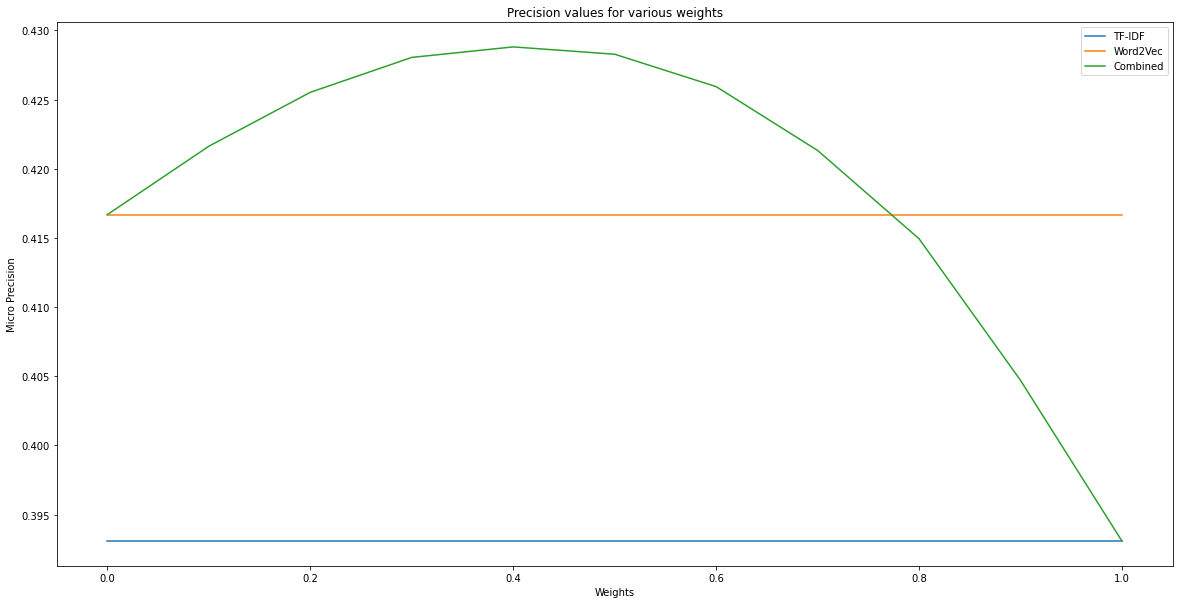

In [31]:
import matplotlib.pyplot as plt

with open(RESULTS_FILE_PATH, 'w') as f:
    json.dump(result_list, f)

np_array = np.array(result_list)

plt.figure(figsize=(20,10))
plt.title(f"Precision values for various weights")
plt.xlabel('Weights')
plt.ylabel('Micro Precision')

p1 = plt.plot(weights, np_array[:,0,0], label="TF-IDF")
p2 = plt.plot(weights, np_array[:,1,0], label="Word2Vec")
p3 = plt.plot(weights, np_array[:,2,0], label="Combined")

leg = plt.legend()

#### Recall values for different values of weights 

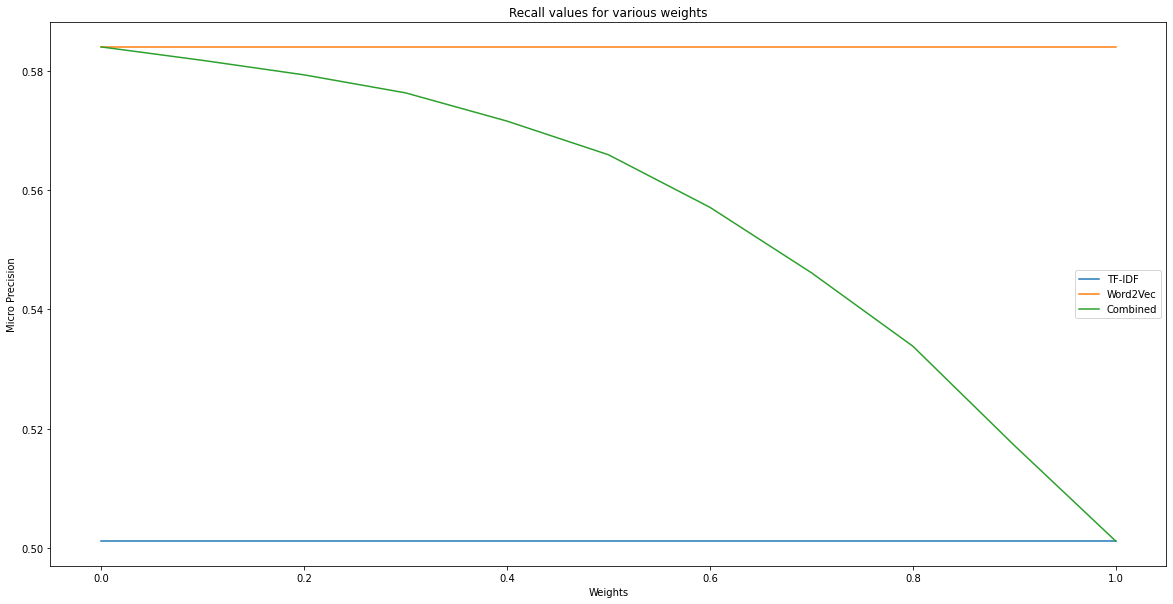

In [32]:
plt.figure(figsize=(20,10))
plt.title(f"Recall values for various weights")
plt.xlabel('Weights')
plt.ylabel('Micro Precision')

p1 = plt.plot(weights, np_array[:,0,1], label="TF-IDF")
p2 = plt.plot(weights, np_array[:,1,1], label="Word2Vec")
p3 = plt.plot(weights, np_array[:,2,1], label="Combined")

leg = plt.legend()

#### Micro F1 values for different values of weights 

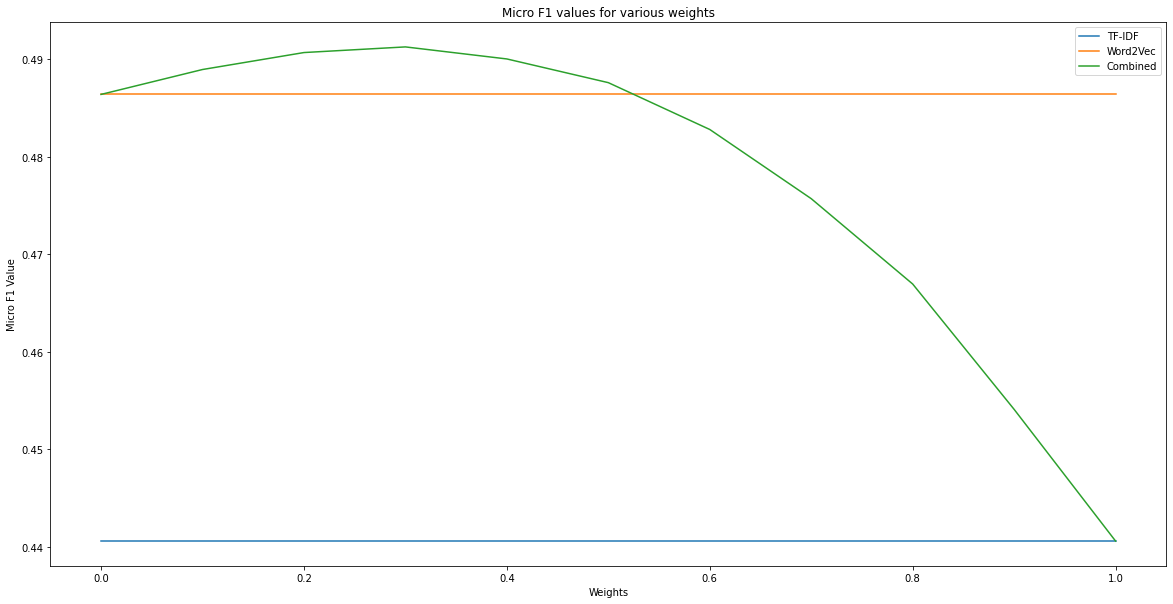

In [33]:
plt.figure(figsize=(20,10))
plt.title(f"Micro F1 values for various weights")
plt.xlabel('Weights')
plt.ylabel('Micro F1 Value')

p1 = plt.plot(weights, np_array[:,0,2], label="TF-IDF")
p2 = plt.plot(weights, np_array[:,1,2], label="Word2Vec")
p3 = plt.plot(weights, np_array[:,2,2], label="Combined")

leg = plt.legend()

#### Micro AUC values for different values of weights 

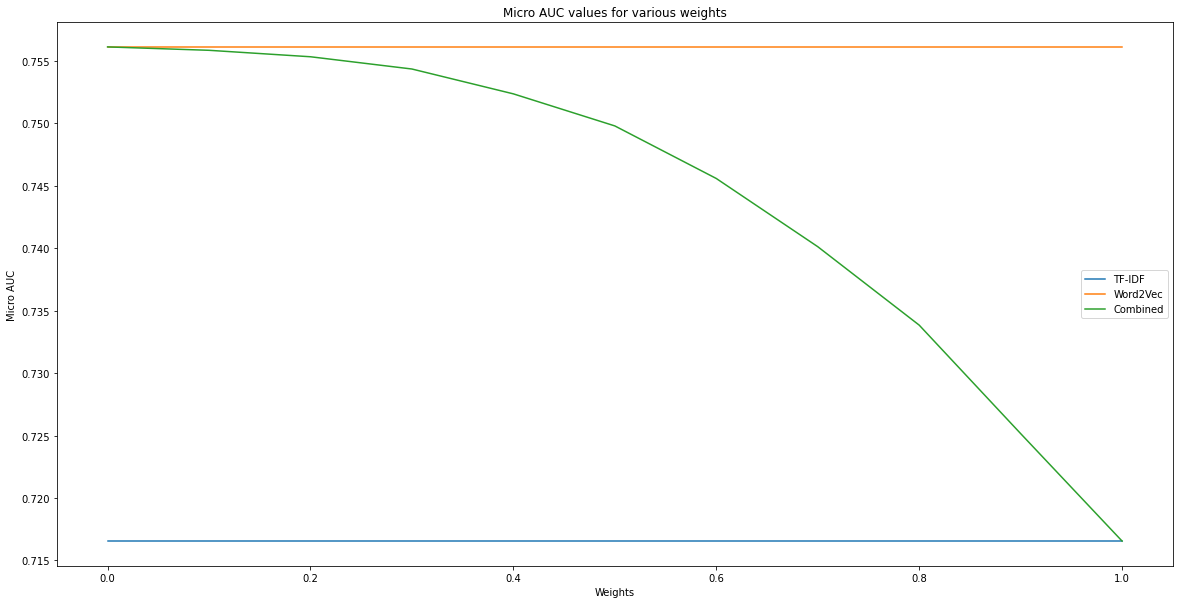

In [34]:
plt.figure(figsize=(20,10))
plt.title(f"Micro AUC values for various weights")
plt.xlabel('Weights')
plt.ylabel('Micro AUC')

p1 = plt.plot(weights, np_array[:,0,3], label="TF-IDF")
p2 = plt.plot(weights, np_array[:,1,3], label="Word2Vec")
p3 = plt.plot(weights, np_array[:,2,3], label="Combined")

leg = plt.legend()